In [40]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel
df = sns.load_dataset('titanic')

df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'

df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df

,survived,is_pclass3,is_female,age
0,0,True,False,22.00
1,1,False,True,38.00
2,1,True,True,26.00
3,1,False,True,35.00
4,0,True,False,35.00
...,...,...,...,...
709,0,True,True,39.00
710,0,False,False,27.00
711,1,False,True,19.00
712,1,False,False,26.00


In [42]:
TREATMENT = 'is_pclass3'
OUTCOME = 'survived'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
True,355.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


# One chuck

Not only we have ATT but also we have confidence interval in this output. In addition, we also get ATE and ATC.

In [41]:
y = df[OUTCOME].values
t = df[TREATMENT].values
X = df[['is_female', 'age']]
X = pd.DataFrame(StandardScaler().fit_transform(X), 
                 columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.259      0.046     -5.623      0.000     -0.350     -0.169
           ATC     -0.292      0.056     -5.240      0.000     -0.401     -0.183
           ATT     -0.227      0.052     -4.400      0.000     -0.328     -0.126



# or we can break it down:

Let’s now inspect the distribution of the confounders by the treatment groups:

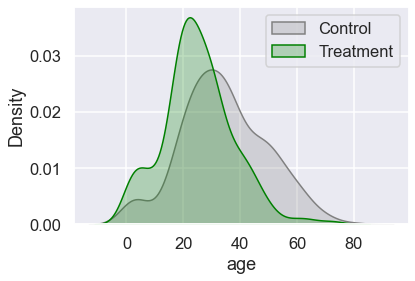

In [7]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
sns.kdeplot(data=df[~df[TREATMENT]], x='age', shade=True, 
            color=C_COLOUR, label=C_LABEL)
sns.kdeplot(data=df[df[TREATMENT]], x='age', shade=True, 
            color=T_COLOUR, label=T_LABEL)
plt.legend();

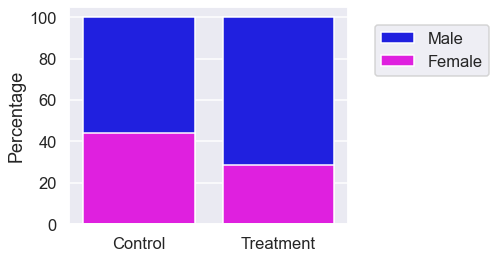

In [8]:
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'
gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL, 
                                                  False: C_LABEL}), 
                           df['is_female'].replace({True: 'Female',
                                                    False: 'Male'}), 
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All", 
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='Female', 
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');

Now we know confounding factors are not balanced between the two groups. Now let’s learn how to make the groups more comparable.

# Build the propensity score matching model

Predicting the probability of receiving the treatment given the confounders. 

## Estimate propensity scores

In [10]:
# Build a descriptive model
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df.head()

,survived,is_pclass3,is_female,age,proba,logit,pred
0,0,True,False,22.00,0.67,0.70,1
1,1,False,True,38.00,0.26,-1.02,0
2,1,True,True,26.00,0.40,-0.40,0
3,1,False,True,35.00,0.30,-0.87,0
4,0,True,False,35.00,0.51,0.03,1


We haven’t partitioned the data into train and test split as we are not building a predictive model. Propensity score tells us the probability of an individual getting the treatment given the confounders. We have also prepared the logit transformation of the propensity score. Let’s assess the model:



In [11]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6695, ROC AUC: 0.7197, F1-score: 0.6776


pred,False,True
is_pclass3,,
False,230,129
True,107,248


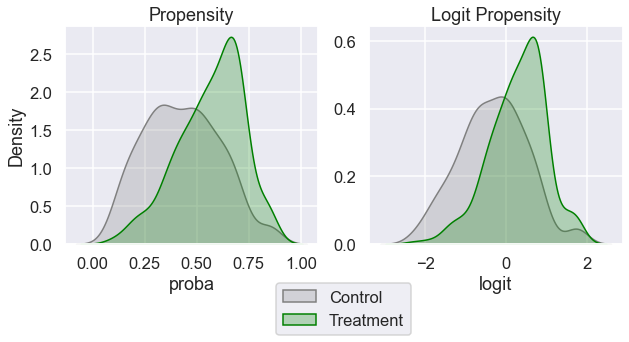

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='proba', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x='proba', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='logit', shade=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]], x='logit', shade=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

We can see that both groups have some overlap in their propensity scores across the range. This is good when it comes to matching.

## Match records

Propensity score is a balancing score. This means, if we match records based on the propensity score, the distribution of the confounders between matched records will be likely similar.

In [13]:
# Sort by 'logit' so it's quicker to find match
df.sort_values('logit', inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()): 
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]: # treatment group
        # Find the closest untreated match among records sorted higher. 
        # equal_or_above would' be more accurate but used 'above' for brevity        
        if i<n:
            above = df.iloc[i:]
            control_above = above[~above[TREATMENT]]
            match_above = control_above.iloc[0]
            distance_above = match_above['logit'] - row['logit']
            df.loc[ind, 'match'] = match_above.name
            df.loc[ind, 'distance'] = distance_above
        
        # Find the closest untreated match among records sorted lower. 
        # 'equal_or_below' would be more accurate but used 'below' for brevity  
        if i>0:
            below = df.iloc[:i-1]
            control_below = below[~below[TREATMENT]]
            match_below = control_below.iloc[-1]
            distance_below = match_below['logit'] - row['logit']
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
            
            # Only overwrite if match_below is closer than match_above
            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
                
df[df[TREATMENT]]

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
385,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
679,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
91,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
586,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
225,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
6,0,True,False,2.00,0.85,1.75,1,329.00,-0.05
132,0,True,False,1.00,0.86,1.80,1,329.00,-0.10
628,1,True,False,1.00,0.86,1.80,1,273.00,-0.05
309,0,True,False,1.00,0.86,1.80,1,273.00,-0.05


We will now create a new dataset called matched_df that contains the original treatment group and a new control group:

In [22]:
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match'])) #find the indexes of matched treated users and control users
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
0,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
2,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
3,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
4,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
705,1,False,False,3.00,0.84,1.69,1,NaN,NaN
706,1,False,False,3.00,0.84,1.69,1,NaN,NaN
707,1,False,False,2.00,0.85,1.75,1,NaN,NaN
708,1,False,False,2.00,0.85,1.75,1,NaN,NaN


## Evaluate matching

In [23]:
COLUMNS = ['age', 'is_female', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT], COLUMNS+['match']], #treated users + their matched users
                   df[COLUMNS], left_on='match',  #matched control users' info
                   right_index=True, 
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,156.00,58.00,True,1
91,70.50,False,0,74.00,71.00,False,0
586,48.00,True,0,25.00,66.00,False,0
225,65.00,False,0,601.00,48.00,True,1
...,...,...,...,...,...,...,...
6,2.00,False,0,329.00,3.00,False,1
132,1.00,False,0,329.00,3.00,False,1
628,1.00,False,1,273.00,2.00,False,1
309,1.00,False,0,273.00,2.00,False,1


Of these 10 examples, treatment records 679, 586, 225 don’t seem very similar to their control matches. However, the matches look quite similar for the remaining 7 examples. Let’s now check the distribution:

In [28]:
for var in ['logit', 'age']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,-0.33,0.84,-2.33,-0.87,-0.29,0.24,1.82
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,0.26,0.70,-2.33,-0.18,0.34,0.76,1.81
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,34.21,15.00,0.67,24.00,33.00,45.00,80.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


age | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,25.06,13.96,0.83,17.00,25.00,32.25,71.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


The distribution looks more similar between the groups now after the matching. Let’s visualise the distributions:

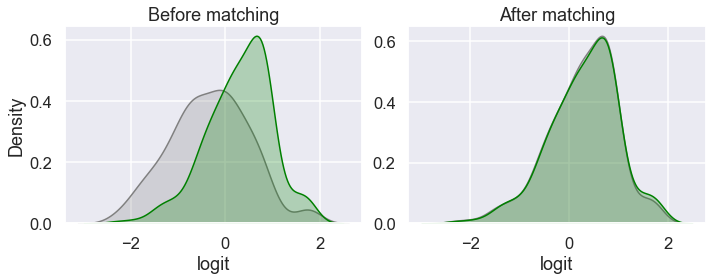

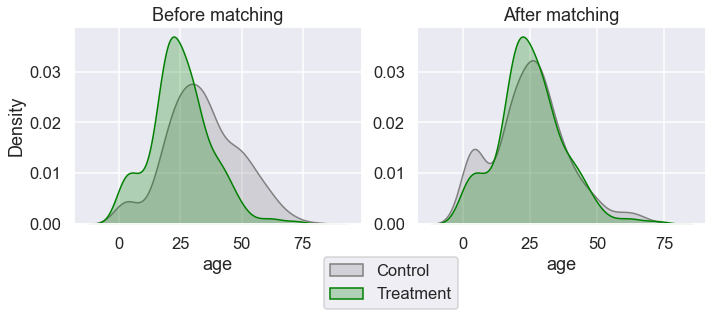

In [31]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, shade=True, 
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, shade=True, 
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                shade=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                shade=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
    
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

Age looks more balanced between the groups than before. Let’s inspect the distribution of gender:

In [32]:
print(f"{'is_female'} | Before matching")
display(pd.crosstab(df[TREATMENT], df['is_female'], 
                    normalize='index'))
print(f"{'is_female'} | After matching")
display(pd.crosstab(matched_df[TREATMENT], matched_df['is_female'], 
            normalize='index'))

is_female | Before matching


is_female,False,True
is_pclass3,,
False,0.56,0.44
True,0.71,0.29


is_female | After matching


is_female,False,True
is_pclass3,,
False,0.68,0.32
True,0.71,0.29


The gender ratio is more similar between the groups.

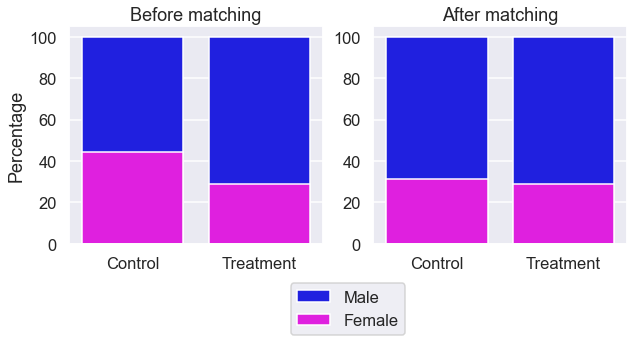

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='Female', 
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['is_female'].replace({True: 'Female', False: 'Male'}), 
    normalize='index'
)
gender_after['All'] = 100
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('');

Once we are happy with the matching and believe the confounding factors are balanced between the groups, we can move on to the next step to understand the causal impact of the treatment.

## Evaluate treatment effect on the outcome

In [36]:
att = np.mean(matches['survived_t']-matches['survived_c'])
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.2169
